<a href="https://colab.research.google.com/github/ekanathi/ekanathi/blob/main/Kaggle_No_Show_Appointments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
 #import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler



In [7]:
#load data

from google.colab import files
uploaded = files.upload()

Saving kaggle_no_show_appointments.csv to kaggle_no_show_appointments.csv


In [9]:
df=pd.read_csv('kaggle_no_show_appointments.csv')

In [10]:
df.head(2)

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No


## 2. Understanding Data
### Basic Summary

In [11]:
print(df.info())



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   PatientId       110527 non-null  float64
 1   AppointmentID   110527 non-null  int64  
 2   Gender          110527 non-null  object 
 3   ScheduledDay    110527 non-null  object 
 4   AppointmentDay  110527 non-null  object 
 5   Age             110527 non-null  int64  
 6   Neighbourhood   110527 non-null  object 
 7   Scholarship     110527 non-null  int64  
 8   Hipertension    110527 non-null  int64  
 9   Diabetes        110527 non-null  int64  
 10  Alcoholism      110527 non-null  int64  
 11  Handcap         110527 non-null  int64  
 12  SMS_received    110527 non-null  int64  
 13  No-show         110527 non-null  object 
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB
None


In [12]:
print(df.describe())

          PatientId  AppointmentID            Age    Scholarship  \
count  1.105270e+05   1.105270e+05  110527.000000  110527.000000   
mean   1.474963e+14   5.675305e+06      37.088874       0.098266   
std    2.560949e+14   7.129575e+04      23.110205       0.297675   
min    3.921784e+04   5.030230e+06      -1.000000       0.000000   
25%    4.172614e+12   5.640286e+06      18.000000       0.000000   
50%    3.173184e+13   5.680573e+06      37.000000       0.000000   
75%    9.439172e+13   5.725524e+06      55.000000       0.000000   
max    9.999816e+14   5.790484e+06     115.000000       1.000000   

        Hipertension       Diabetes     Alcoholism        Handcap  \
count  110527.000000  110527.000000  110527.000000  110527.000000   
mean        0.197246       0.071865       0.030400       0.022248   
std         0.397921       0.258265       0.171686       0.161543   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       0.000000       

In [14]:
# Check missing values
print(df.isnull().sum())

PatientId         0
AppointmentID     0
Gender            0
ScheduledDay      0
AppointmentDay    0
Age               0
Neighbourhood     0
Scholarship       0
Hipertension      0
Diabetes          0
Alcoholism        0
Handcap           0
SMS_received      0
No-show           0
dtype: int64


In [15]:
# Summary of numerical columns
df[["Age"]].describe()

,Age
count,110527.000000
mean,37.088874
std,23.110205
min,-1.000000
25%,18.000000
50%,37.000000
75%,55.000000
max,115.000000


In [16]:
df[["Age"]].value_counts()

,count
Age,
0,3539
1,2273
52,1746
49,1652
53,1651
...,...
115,5
100,4
102,2


### Correlation Analysis

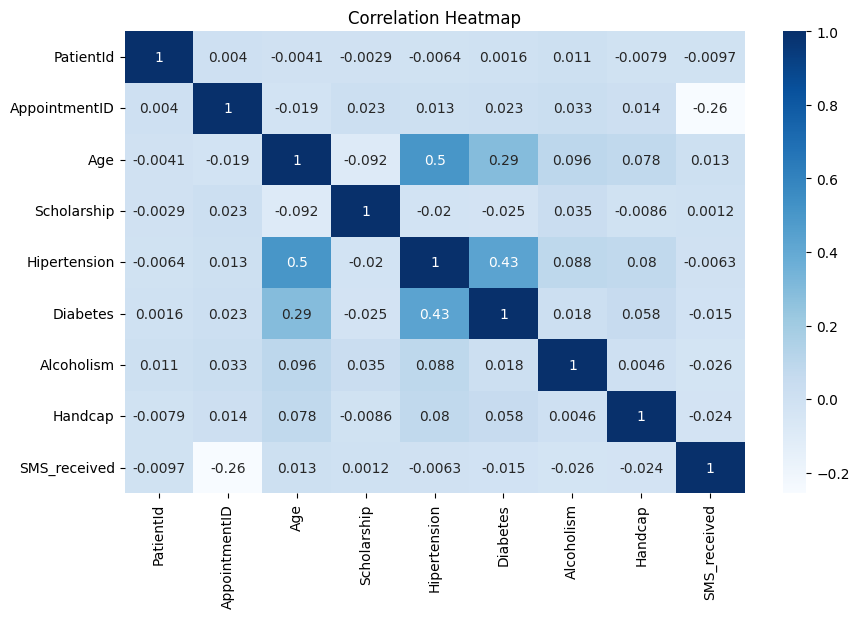

In [17]:
# Correlation heatmap
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='Blues')
plt.title("Correlation Heatmap")
plt.show()


### Visualization

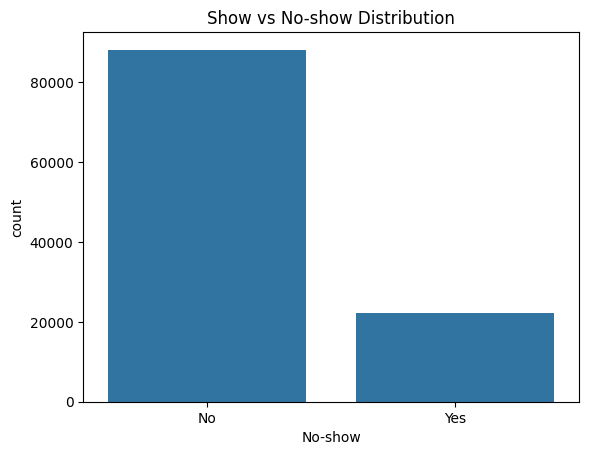

In [18]:
# No-show distribution

sns.countplot(x='No-show', data=df)
plt.title("Show vs No-show Distribution")
plt.show()


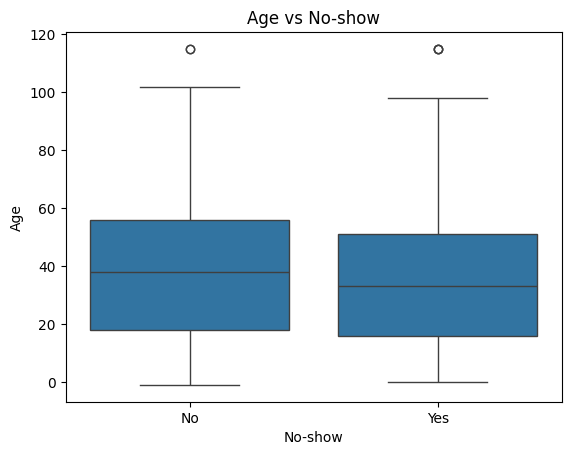

In [19]:
# Age vs No-show

sns.boxplot(x='No-show', y='Age', data=df)
plt.title("Age vs No-show")
plt.show()

### Initial Insights
- No-shows account for around 20% of all appointments.
- Younger patients are slightly more likely to miss appointments.
- Some health conditions (e.g., hypertension) appear to be negatively correlated with no-shows — possibly due to increased urgency.
- SMS reminders alone may not guarantee attendance, especially for younger demographics.


## 3. Data Preparation
### Preapare data for machine learning
- handle missing values
- detect and treat outliers
- encode cartegorical variables
- scale/normaize features
- feature engineering/selection
- dimensionality reduction

In [20]:
# handle missing values
# drop any columns with too many missing values (if any)
df.dropna(axis=1, thresh=int(0.5 * len(df)), inplace=True)


In [21]:
# remove duplicates and outliers
df.drop_duplicates(inplace=True)

In [22]:
# remove negative ages
df=df[df["Age"]>=0]

In [23]:
# Convert ScheduledDay and AppointmentDay to datetime
df['ScheduledDay'] = pd.to_datetime(df['ScheduledDay'])
df['AppointmentDay'] = pd.to_datetime(df['AppointmentDay'])

In [24]:
# Create a new feature: waiting days
df['WaitingDays'] = (df['AppointmentDay'] - df['ScheduledDay']).dt.days
df = df[df['WaitingDays'] >= 0]  # Drop if scheduled after appointment

In [25]:
# Convert No-show to binary (1 if No-show, 0 if Show)
df['No-show'] = df['No-show'].map({'Yes': 1, 'No': 0})


In [26]:
# Label encode Gender and other binary columns
le = LabelEncoder()
df['Gender'] = le.fit_transform(df['Gender'])

In [27]:
# One-hot encode Neighbourhood
df = pd.get_dummies(df, columns=['Neighbourhood'], drop_first=True)

In [28]:
# drop irrelevant columns
df.drop(['PatientId', 'AppointmentID', 'ScheduledDay', 'AppointmentDay'], axis=1, inplace=True)

In [30]:
# feature scaling
scaler = StandardScaler()
scaled_features = ['Age', 'WaitingDays']
df[scaled_features] = scaler.fit_transform(df[scaled_features])

In [31]:
# split features and label
X = df.drop('No-show', axis=1)
y = df['No-show']
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## 4.	Modelling
- Train, evaluate, and interpret machine learning models to predict patient no-shows.
- Chosen Algorithm: Logistic Regression because - it is simple & interpretable, performs well for binary classification problems, and outputs probabilities, useful for ROC-AUC analysis.


In [32]:
# importing libraries
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix, RocCurveDisplay
import matplotlib.pyplot as plt
import seaborn as sns

In [33]:
# model training
model = LogisticRegression(max_iter=1000)
model.fit(x_train, y_train)

LogisticRegression(max_iter=1000)

In [34]:
# predictions
y_pred = model.predict(x_test)
y_proba = model.predict_proba(x_test)[:, 1]  # For ROC-AUC

In [35]:
# 3. Metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_proba))

Accuracy: 0.7149805447470817
Precision: 0.37777777777777777
Recall: 0.004155463211928624
F1 Score: 0.008220502901353965
ROC-AUC: 0.5890642171730875


In [36]:
# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.72      1.00      0.83     10301
           1       0.38      0.00      0.01      4091

    accuracy                           0.71     14392
   macro avg       0.55      0.50      0.42     14392
weighted avg       0.62      0.71      0.60     14392



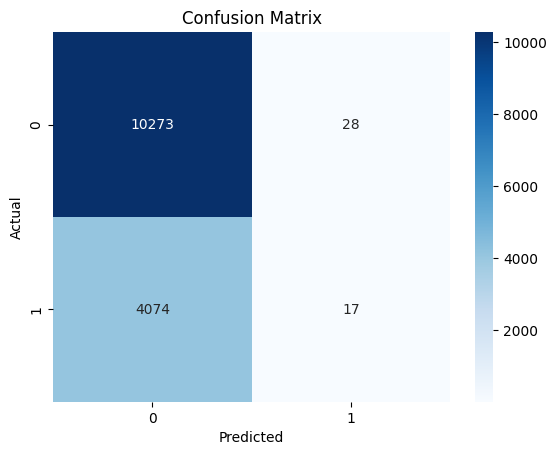

In [37]:
# confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

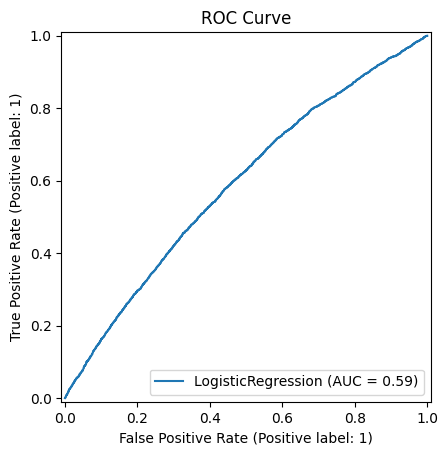

In [38]:
# ROC curve
RocCurveDisplay.from_estimator(model, x_test, y_test)
plt.title("ROC Curve")
plt.show()

In [39]:
# coefficients
coefficients = pd.DataFrame({
    'Feature': x_train.columns,
    'Coefficient': model.coef_[0]
}).sort_values(by='Coefficient', ascending=False)
print(coefficients)


                              Feature  Coefficient
35             Neighbourhood_GURIGICA     0.437422
5                          Alcoholism     0.405619
44              Neighbourhood_ITARARÉ     0.399735
36                Neighbourhood_HORTO     0.346852
11  Neighbourhood_ARIOVALDO FAVALESSA     0.334402
..                                ...          ...
15            Neighbourhood_BOA VISTA    -0.288495
19              Neighbourhood_COMDUSA    -0.322070
24           Neighbourhood_DE LOURDES    -0.404172
25            Neighbourhood_DO CABRAL    -0.408915
80         Neighbourhood_SOLON BORGES    -0.566577

[88 rows x 2 columns]


In [40]:
# tree-based model
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=42)
rf.fit(x_train, y_train)
rf_pred = rf.predict(x_test)
print("Random Forest F1 Score:", f1_score(y_test, rf_pred))


Random Forest F1 Score: 0.2998947210106783


## 5. Evaluation
 - Assess model performance on unseen data.
 - Discuss any evidence of algorithmic bias and mitigation strategies.
 - Perform error analysis and interpret the results.

In [41]:
# algorithmic bias

df.groupby('Gender')['No-show'].mean()

,No-show
Gender,
0,0.284460
1,0.286659


No-show rates by gender:
 Gender
0    0.284460
1    0.286659
Name: No-show, dtype: float64


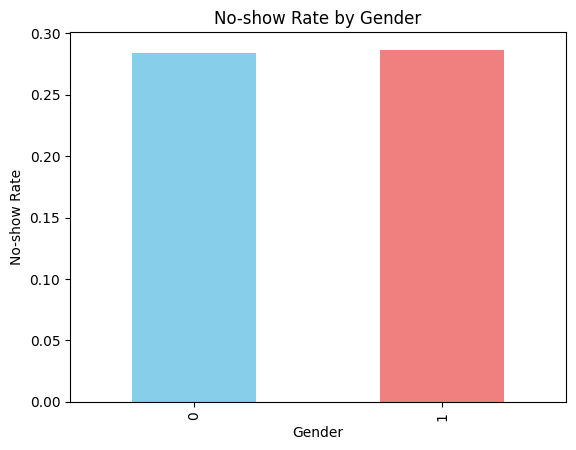

In [42]:
# Check average no-show rate by gender
gender_noshow = df.groupby('Gender')['No-show'].mean()
print("No-show rates by gender:\n", gender_noshow)

# Bar plot
gender_noshow.plot(kind='bar', title='No-show Rate by Gender', color=['skyblue', 'lightcoral'])
plt.ylabel('No-show Rate')
plt.show()


<Axes: >

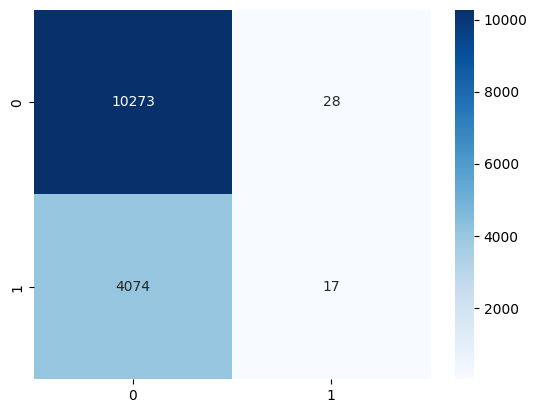

In [43]:
# error analysis
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')


## 6. Deployment